In [1]:
import pandas_datareader as pdr
import pandas as pd
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
key="c2ed96ce8d8e74af08ec95a327493aaa69fa5a9e"

In [15]:
df=pdr.get_iex_data_tiingo('AAPL',api_key=key)

In [16]:
df.head()

close     high      low     open
symbol date                                                         
AAPL   2021-01-21 17:15:00+00:00  135.390  135.530  135.215  135.470
       2021-01-21 17:20:00+00:00  135.695  135.720  135.340  135.405
       2021-01-21 17:25:00+00:00  135.860  135.985  135.640  135.680
       2021-01-21 17:30:00+00:00  135.750  135.870  135.630  135.855
       2021-01-21 17:35:00+00:00  135.980  136.020  135.725  135.740

In [17]:
df.shape

(10000, 4)

In [2]:
path="/content/drive/MyDrive/Colab Notebooks/NLP/Stock data/apple.csv"

In [19]:
df.to_csv(path)

In [3]:
df=pd.read_csv(path)

In [4]:
df.shape

(10000, 6)

In [5]:
df1=df.reset_index()['close']

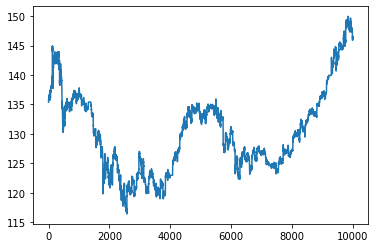

In [6]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [7]:
import numpy as np

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

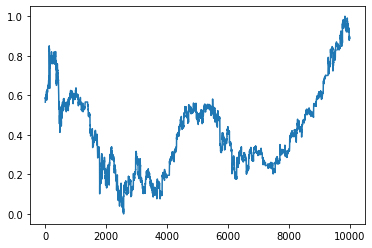

In [9]:
plt.plot(df1)

In [10]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [11]:
train_data.shape,test_data.shape

((6500, 1), (3500, 1))

In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [13]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 1000
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [14]:
X_train.shape

(5499, 1000)

In [15]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [17]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1000,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1000, 50)          10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 50)          20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
86/86 [==============================] - 20s 117ms/step - loss: 0.0057 - val_loss: 8.9620e-04
Epoch 2/100
86/86 [==============================] - 9s 104ms/step - loss: 4.6728e-04 - val_loss: 5.5872e-04
Epoch 3/100
86/86 [==============================] - 9s 105ms/step - loss: 4.3947e-04 - val_loss: 3.4990e-04
Epoch 4/100
86/86 [==============================] - 9s 105ms/step - loss: 4.1170e-04 - val_loss: 2.6090e-04
Epoch 5/100
86/86 [==============================] - 9s 105ms/step - loss: 3.8964e-04 - val_loss: 2.7895e-04
Epoch 6/100
86/86 [==============================] - 9s 108ms/step - loss: 3.6158e-04 - val_loss: 1.7529e-04
Epoch 7/100
86/86 [==============================] - 9s 108ms/step - loss: 3.4011e-04 - val_loss: 4.7698e-04
Epoch 8/100
86/86 [==============================] - 9s 108ms/step - loss: 3.4667e-04 - val_loss: 4.3959e-04
Epoch 9/100
86/86 [==============================] - 9s 105ms/step - loss: 3.0671e-04 - val_loss: 2.4758e-04
Epoch 10/100
86/86 [==

In [20]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [21]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [22]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

127.2018657034791

In [24]:
math.sqrt(mean_squared_error(y_test,test_predict))

134.90637458417572

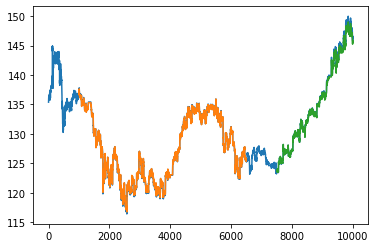

In [26]:
### Plotting 
# shift train predictions for plotting
look_back=1000
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [27]:
len(test_data)

3500

In [37]:
x_input=test_data[2499:].reshape(1,-1)
x_input.shape

(1, 1001)

In [38]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [30]:
temp_input

[0.6036948748510129,
 0.6050357568533968,
 0.6039928486293205,
 0.6033969010727054,
 0.6072705601907034,
 0.6078665077473184,
 0.6099523241954703,
 0.6056317044100119,
 0.60041716328963,
 0.6038438617401667,
 0.6038438617401667,
 0.6065256257449345,
 0.6056317044100119,
 0.6065256257449345,
 0.6044398092967826,
 0.6059296781883194,
 0.6051847437425506,
 0.6072705601907034,
 0.6069725864123958,
 0.6077175208581647,
 0.608164481525626,
 0.6109952324195476,
 0.6124851013110844,
 0.6118891537544702,
 0.6120381406436239,
 0.6111442193087013,
 0.6126340882002381,
 0.6105482717520854,
 0.6066746126340883,
 0.6065256257449345,
 0.6093563766388561,
 0.6074195470798571,
 0.6117401668653155,
 0.6138259833134692,
 0.6132300357568532,
 0.613974970202622,
 0.6121871275327768,
 0.6099523241954703,
 0.6106972586412391,
 0.6126340882002381,
 0.6142729439809296,
 0.6148688915375446,
 0.6179976162097738,
 0.6199344457687719,
 0.6202324195470803,
 0.6212753277711567,
 0.6217222884386171,
 0.61993444576877

In [39]:
# demonstrate prediction for next 10 days
lst_output=[]
n_steps=1000
i=0
while(i<30):  
    if(len(temp_input)>1000):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

Streaming output truncated to the last 5000 lines.
 0.70038737 0.70038737 0.70038737 0.70038737 0.70038737 0.70038737
 0.70038737 0.70038737 0.70038737 0.70038737 0.70038737 0.70038737
 0.70038737 0.70038737 0.70038737 0.70038737 0.70038737 0.70038737
 0.70038737 0.70038737 0.70038737 0.70038737 0.70038737 0.70038737
 0.70038737 0.70038737 0.70038737 0.70038737 0.70038737 0.70038737
 0.70038737 0.70038737 0.70038737 0.70038737 0.70038737 0.70038737
 0.70038737 0.70038737 0.70038737 0.70038737 0.70038737 0.70038737
 0.70038737 0.71543504 0.73495232 0.74463647 0.76728248 0.77786055
 0.78426698 0.79216329 0.78575685 0.78903456 0.77651967 0.77875447
 0.78873659 0.76311085 0.761323   0.76966627 0.77398689 0.76564362
 0.75655542 0.75610846 0.76072706 0.75104291 0.75506555 0.7534267
 0.75625745 0.75491657 0.76147199 0.75       0.73927294 0.7465733
 0.74940405 0.74225268 0.72377831 0.72720501 0.70887962 0.72109654
 0.71945769 0.72646007 0.72824791 0.73584625 0.74284863 0.74910608
 0.75074493 0

In [40]:
day_new=np.arange(1,1001)
day_pred=np.arange(1001,1031)

In [41]:
len(df1)

10000

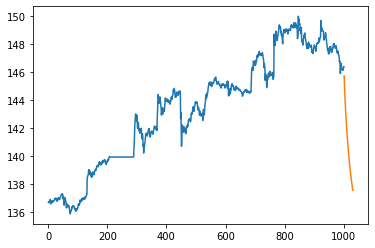

In [42]:
plt.plot(day_new,scaler.inverse_transform(df1[9000:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))